# Assignment 9

- Joel Oliveira - fc59442
- João Braz - fc60419

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [ ]:
ds = tfds.load("imagenet_v2", as_supervised=True)["test"]

In [ ]:
from random import choice, seed
seed(123)

In [ ]:
idx = choice(range(len(ds)))
idx

857

In [ ]:
it = ds.as_numpy_iterator()
for i in range(idx):
  img_data, img_class = next(it)

In [ ]:
img_class

569

In [ ]:
imagenet_labels[img_class+1]

'garbage truck'

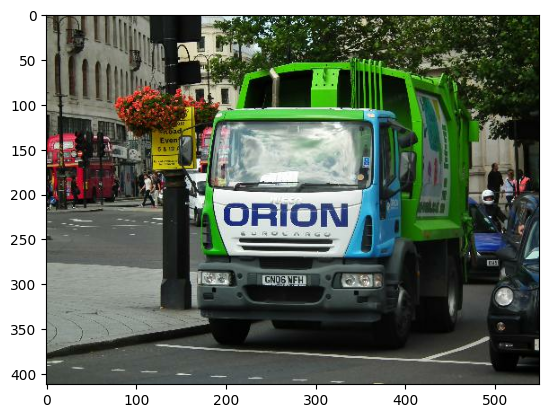

In [ ]:
plt.imshow(img_data)

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

In [ ]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

In [ ]:
org_img = preprocess(img_data)

In [ ]:
image_probs = pretrained_model.predict(org_img)
np.argmax(image_probs)

1/1 [==============================] - 1s 1s/step


569

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
label = tf.one_hot(idx, image_probs.shape[-1])

In [ ]:
label = tf.reshape(label, (1, image_probs.shape[-1]))

In [ ]:
perturbations = create_adversarial_pattern(org_img, label)

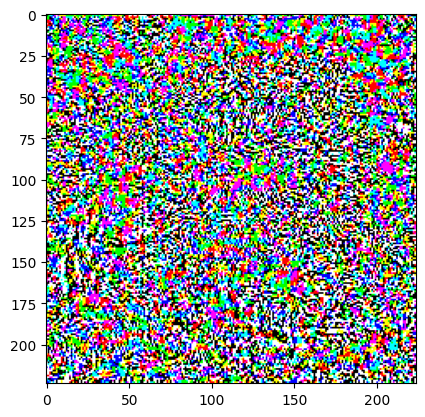

In [ ]:
plt.imshow(perturbations[0] * 0.5 + 0.5);

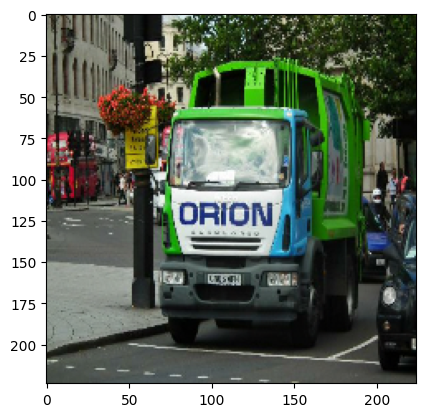

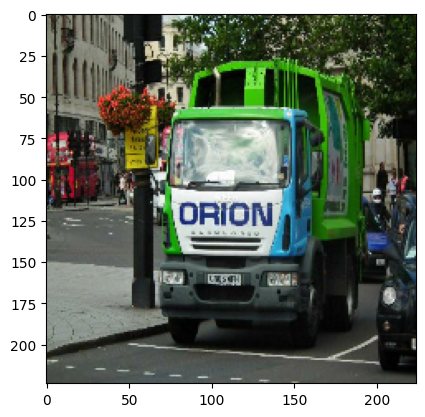

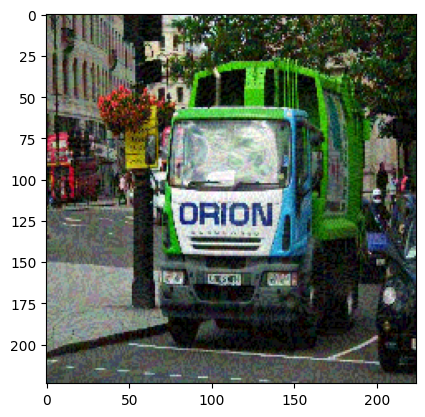

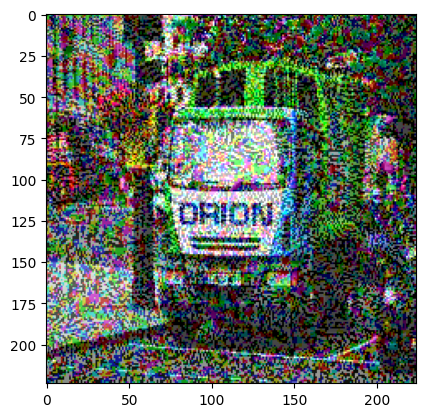

In [ ]:
for i in [0.007, 0.01, 0.1, 0.5]:
  temp_img = org_img + i*perturbations
  temp_img = tf.clip_by_value(temp_img, -1, 1)
  plt.figure()
  plt.imshow(temp_img[0]*0.5+0.5)

In [ ]:
for i in [0, 0.007, 0.01, 0.1, 0.5]:
  temp_img = org_img + i*perturbations
  temp_img = tf.clip_by_value(temp_img, -1, 1)

  pred_probs = pretrained_model.predict(temp_img)
  loc = np.argmax(pred_probs)
  print(pred_probs[0,loc], imagenet_labels[loc+1])

1/1 [==============================] - 0s 100ms/step
0.58043844 garbage truck
1/1 [==============================] - 0s 59ms/step
0.92862743 garbage truck
1/1 [==============================] - 0s 58ms/step
0.94381636 garbage truck
1/1 [==============================] - 0s 111ms/step
0.34728113 garbage truck
1/1 [==============================] - 0s 94ms/step
0.2845304 prayer rug


In [ ]:
pred_probs = pretrained_model.predict(perturbations)
loc = np.argmax(pred_probs)
print(pred_probs[0, loc], imagenet_labels[loc+1])

1/1 [==============================] - 0s 94ms/step
0.16118476 bubble


## Problem 2

To make the models more robust to adverserial attacks, a very straight forward way is to use this type of attacks in the training data. With tthis the model is not so sensitive to the small noise perturbances.